# imports

In [286]:
from importlib import reload
from collections import namedtuple
import inspect
from itertools import groupby
from datetime import date
from functional import seq
from functools import reduce, partial
from glob import glob
import datetime
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import pickle
import re
import seaborn as sns
import shutil
import cv2
#import skimage
#from skimage import io
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tqdm import tqdm, trange
import uuid
from IPython import display

%matplotlib inline
#plt.style.use("dark_background")

import sys
#from drosophpose.GUI import skeleton

from som_vae import somvae_model
from som_vae.utils import *

from som_vae.helpers.misc import extract_args, chunks, foldl
from som_vae.helpers.jupyter import fix_layout, display_video
from som_vae.settings import config, skeleton
from som_vae.helpers import video, plots
from som_vae import preprocessing
from som_vae.helpers.logging import enable_logging
    
fix_layout()
enable_logging()

2019-04-11 19:34:21,983 - root - INFO - logging - logging enabled for level: 20


# playground

In [ ]:
def get_path_for_image(d, frame_id):
    base = config.PATH_EXPERIMENT.format(base_path=config.__EXPERIMENT_ROOT__, 
                                         study_id=d.study_id,
                                         fly_id=d.fly_id,
                                         experiment_id=d.experiment_id)

    path_image = config.PATH_EXPERIMENT_IMAGE.format(base_experiment_path=base,
                                                      camera_id=config.CAMERA_OF_INTEREST)
    
    return path_image.format(image_id=frame_id)

In [ ]:
# WIP
# get all images for each experiment
experiments_with_images = seq(data.EXPERIMENTS).map(lambda x: (x, [(i, cv2.imread(p)) for i, p in config.images_paths(x)])).to_list()

experiments_with_images[0][1]

def _n_frames_per_experiment_(labelled_data):
    return seq(labelled_data)\
        .flat_map(lambda x: ((data._key_(x), frame_id) for frame_id in range(*x.sequence)))\
        .count_by_key()

In [ ]:
reload(config)
reload(data)
reload(video)

# TODO adapt the file path setting
_t = data.LABELLED_DATA[0]
video_path = config.EXPERIMENT_VIDEO_PATH.format(experiment_id=config.full_experiment_id(_t.study_id, _t.experiment_id, _t.fly_id), begin='full', end='video')

params = {"fontFace": 1,
          "fontScale": 1,
          "color": (255, 255, 255),
          "thickness": 1}

def add_texts(x):
    frame = cv2.putText(x[1], 
                        text=f"frame: {x[0]:0>4}: label: {x[2].name}",
                        org=(0, 12), 
                        **{**params, 'color': video._BEHAVIOR_COLORS_[x[2]]})
    # 
    frame = cv2.putText(frame, 
                        text=f"{x[3]}",
                        org=(x[1].shape[1] // 2, 12), 
                        **params)
    
    return frame

frames = seq(data.LABELLED_DATA)\
  .sorted(key=lambda x: (x.label.value, config.full_experiment_id(study_id=x.study_id, experiment_id=x.experiment_id, fly_id=x.fly_id)))\
  .flat_map(lambda x: [(frame_id , 
                        cv2.imread(config.get_path_for_image(x, frame_id)),
                        x.label,
                        config.full_experiment_id(study_id=x.study_id, experiment_id=x.experiment_id, fly_id=x.fly_id)) 
                       for frame_id in range(*x.sequence)])\
  .map(add_texts)

video._save_frames_(video_path, frames, format='mp4')


display_video(video_path)

In [ ]:
path_experiment = config.PATH_EXPERIMENT.format(base_path=config.__PATH_TO_DATA__,
                                                study_id=config.STUDY_ID,
                                                fly_id=config.FLY_ID,
                                                experiment_id=config.EXPERIMENT_ID)

path_experiment_images = pathlib.Path(config.PATH_EXPERIMENT_IMAGE.format(base_experiment_path=path_experiment,
                                                             camera_id=config.CAMERA_OF_INTEREST,
                                                             image_id=0)).parent

In [ ]:
Frame = namedtuple('Frame', 'frame_id, path, camera_id, frame')

def _to_frame_(path, camera_id=config.CAMERA_OF_INTEREST):
    m = re.match('camera_' + str(camera_id) + '_img_(\d{6})\.jpg', path.name)
    
    if m is not None:
        return int(m[1]), path, camera_id, cv2.imread(str(path))
    else:
        return None
    
def get_frames(path, camera_id=config.CAMERA_OF_INTEREST):
    # parent is important here
    _t = seq(pathlib.Path(path).iterdir())\
        .map(partial(_to_frame_, camera_id=camera_id))\
        .filter(lambda x: x is not None)\
        .map(Frame._make)
    
    return _t

# data loading

In [ ]:
#joint_positions = foldl(preprocessing.get_data(), 
#                        preprocessing.add_third_dimension,
#                        preprocessing.get_only_first_legs)[:, :, :config.NB_DIMS]
#
#NB_FRAMES = joint_positions.shape[0]
#__N_INPUT__ = len(config.LEGS) * config.NB_TRACKED_POINTS

In [336]:
from som_vae.helpers.misc import foldl
from som_vae import settings

joint_positions = settings.data.EXPERIMENTS\
    .map(config.positional_data)\
    .map(preprocessing._simple_checks_)\
    .map(preprocessing._get_camera_of_interest_)\
    .map(preprocessing._get_visible_legs_)\
    .map(preprocessing.add_third_dimension)\
    .map(preprocessing.get_only_first_legs)\
    .to_list()

joint_positions, normalisation_factors = preprocessing.normalize(np.vstack(joint_positions))

2019-04-11 19:50:42,416 - root - WARNING - preprocessing - this works only for the first legs!
2019-04-11 19:50:42,573 - root - WARNING - preprocessing - this works only for the first legs!
2019-04-11 19:50:42,726 - root - WARNING - preprocessing - this works only for the first legs!
2019-04-11 19:50:42,885 - root - WARNING - preprocessing - this works only for the first legs!
2019-04-11 19:50:43,041 - root - WARNING - preprocessing - this works only for the first legs!


In [288]:
joint_positions.shape

(4496, 15, 3)

In [316]:
# TODO for some reason some positions are missing
frames_idx_with_labels = seq(settings.data.LABELLED_DATA).flat_map(lambda x: [(i, x.label) for i in range(*x.sequence)]).to_pandas()[:len(joint_positions)]
frames_idx_with_labels.columns = ['frame_id_in_experiment', 'label']

In [337]:
#frames_of_interest = frames_idx_with_labels.label.isin([settings.data._BehaviorLabel_.GROOM_ANT, settings.data._BehaviorLabel_.WALK_FORW, settings.data._BehaviorLabel_.REST])
frames_of_interest = ~frames_idx_with_labels.label.isin([settings.data._BehaviorLabel_.REST])

joint_positions = joint_positions[frames_of_interest]

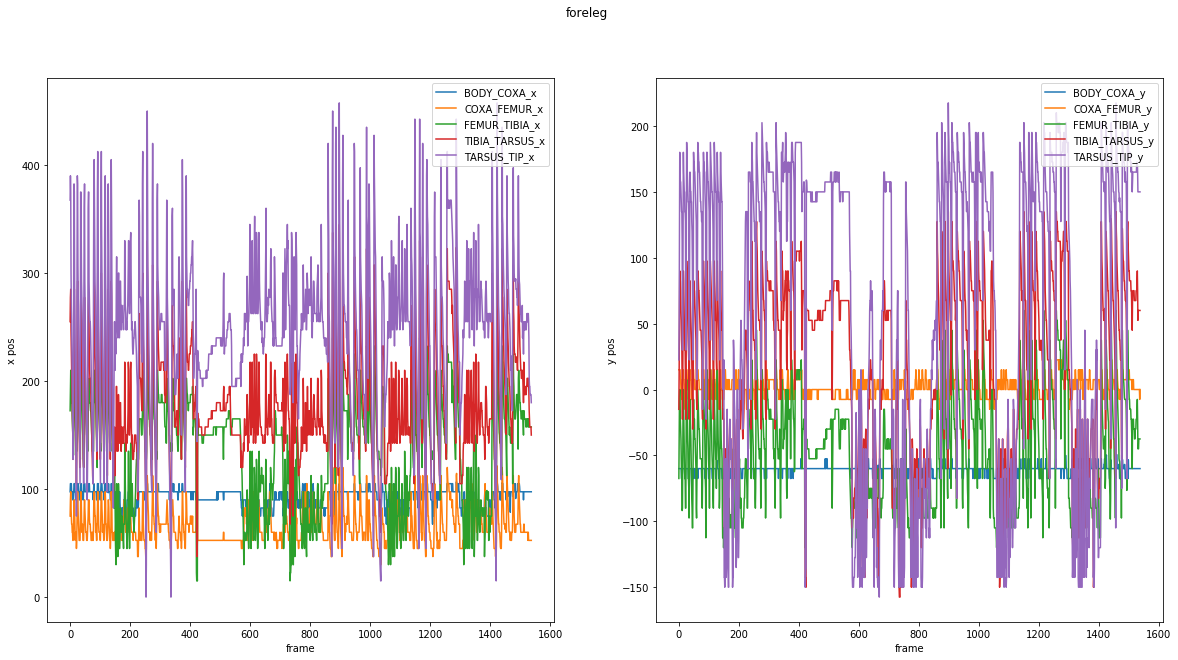

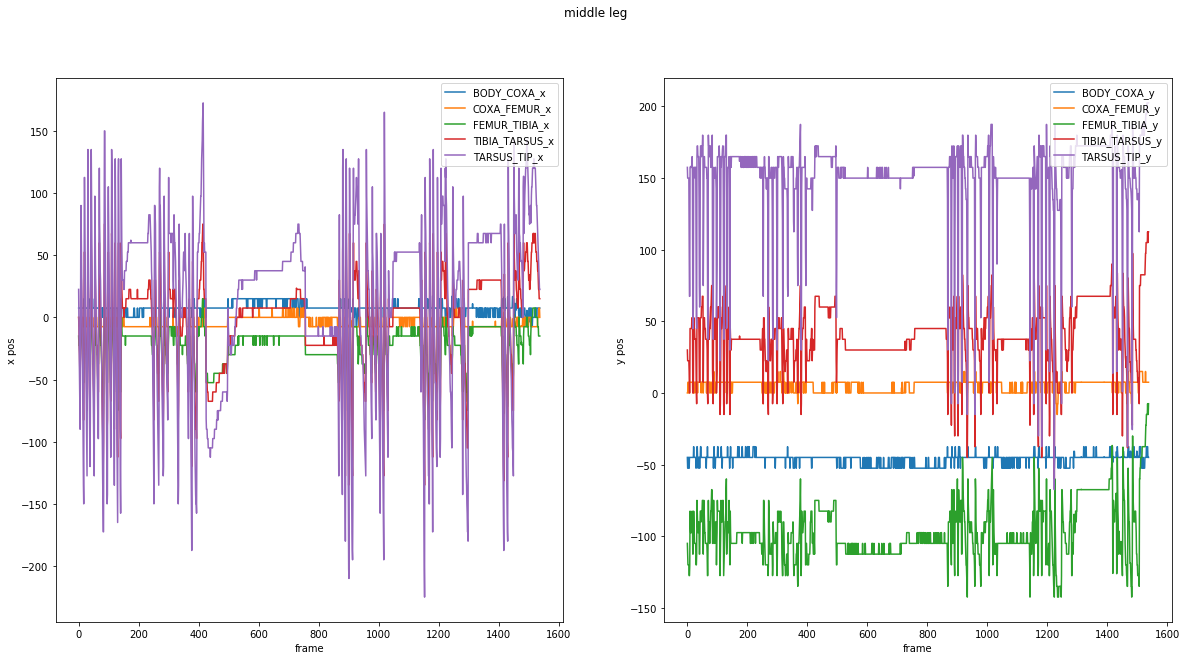

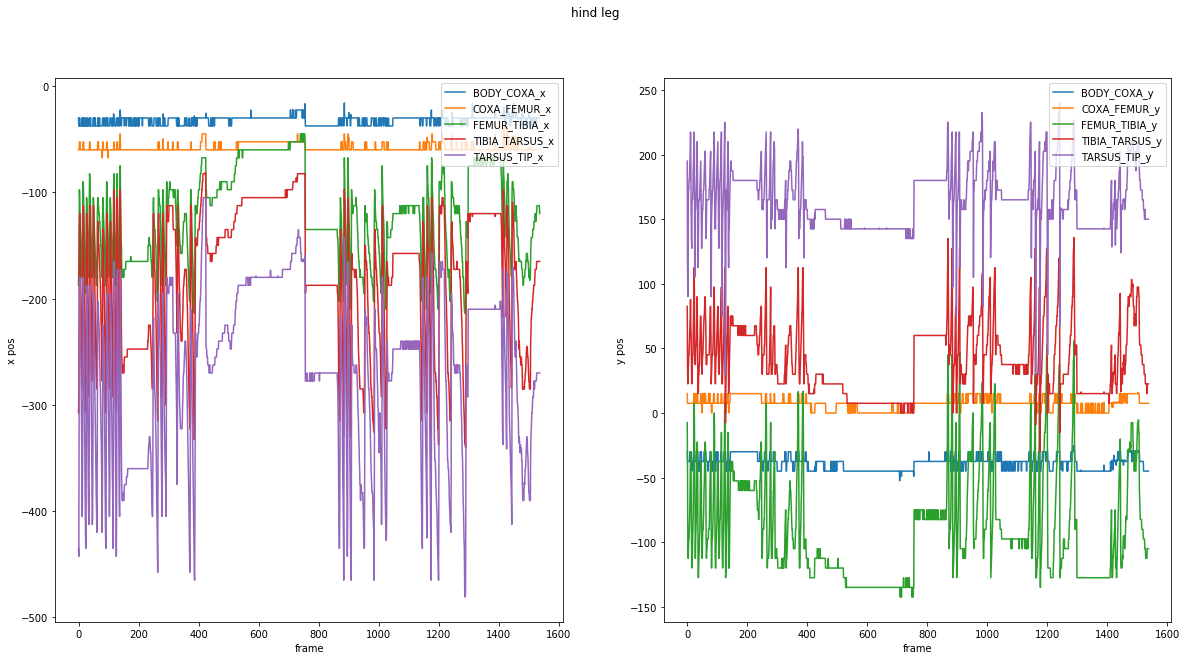

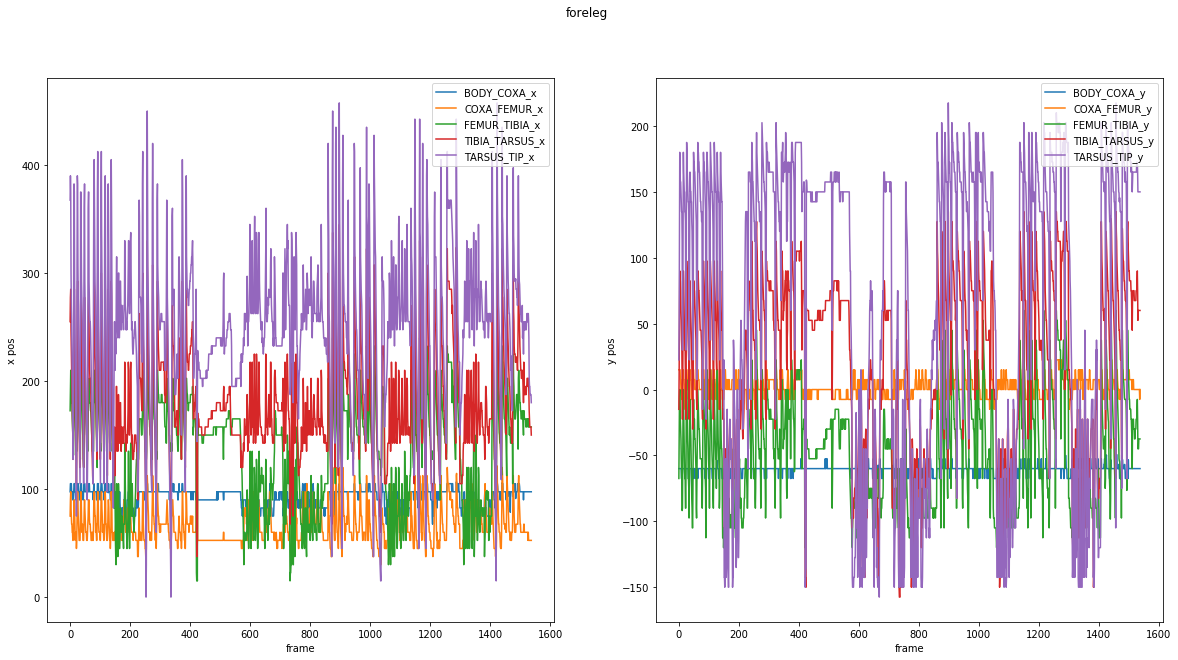

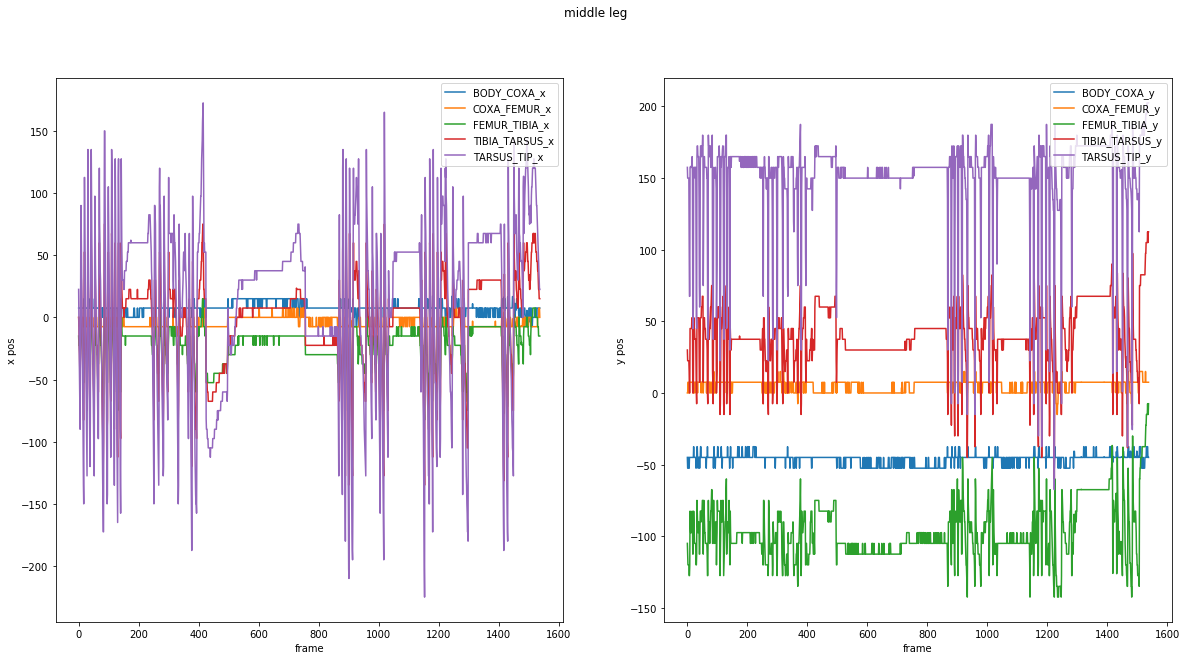

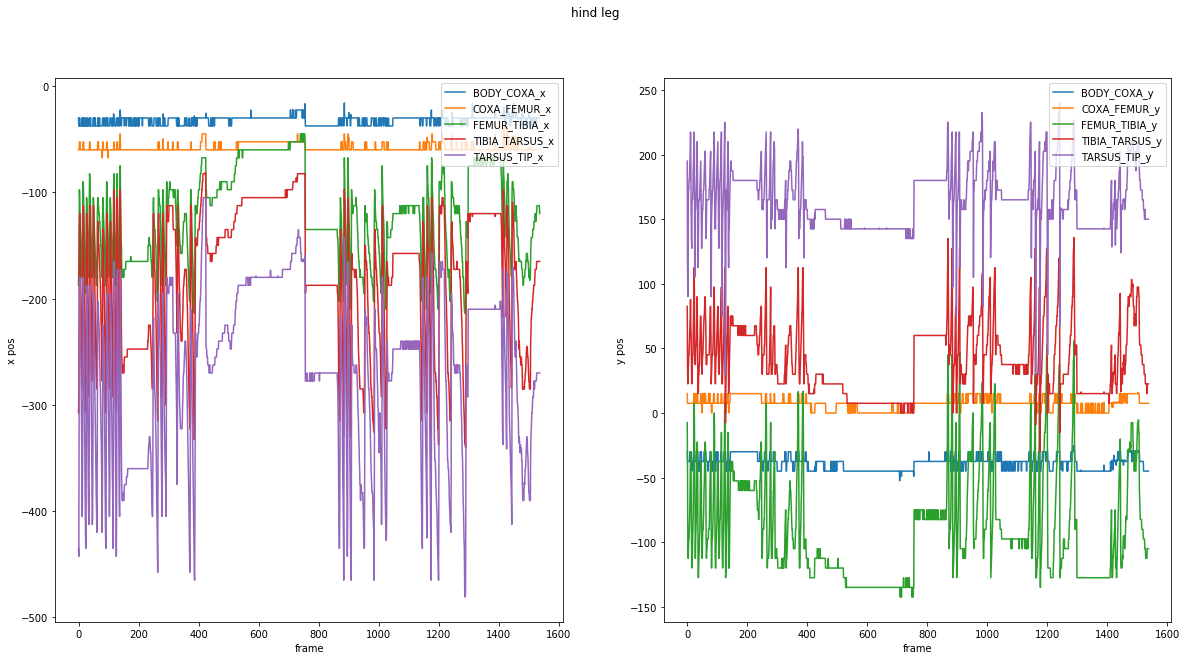

In [338]:
plots.ploting_frames(joint_positions)
plots.ploting_frames(joint_positions - joint_norm_factor)

# SOM-VAE model

## constant

In [339]:
__TF_DEFAULT_SESSION_CONFIG__ = tf.ConfigProto()
__TF_DEFAULT_SESSION_CONFIG__.gpu_options.allow_growth = True 
__TF_DEFAULT_SESSION_CONFIG__.gpu_options.polling_inactive_delay_msecs = 10

## functions

In [340]:
def get_data_generator(data_train, labels_train, data_val, labels_val, time_series):
    """Creates a data generator for the training.
    
    Args:
        time_series (bool): Indicates whether or not we want interpolated MNIST time series or just
            normal MNIST batches.
    
    Returns:
        generator: Data generator for the batches."""

    def batch_generator(mode="train", batch_size=100):
        """Generator for the data batches.
        
        Args:
            mode (str): Mode in ['train', 'val'] that decides which data set the generator
                samples from (default: 'train').
            batch_size (int): The size of the batches (default: 100).
            
        Yields:
            np.array: Data batch.
        """
        assert mode in ["train", "val"], "The mode should be in {train, val}."
        if mode=="train":
            images = data_train.copy()
            labels = labels_train.copy()
        elif mode=="val":
            images = data_val.copy()
            labels = labels_val.copy()
        
        while True:
            indices = np.random.permutation(np.arange(len(images)))
            images = images[indices]
            labels = labels[indices]

            if time_series:
                for i, image in enumerate(images):
                    start_image = image
                    end_image = images[np.random.choice(np.where(labels == (labels[i] + 1) % 10)[0])]
                    interpolation = interpolate_arrays(start_image, end_image, batch_size)
                    yield interpolation + np.random.normal(scale=0.01, size=interpolation.shape)
            else:
                for i in range(len(images)//batch_size):
                    yield images[i*batch_size:(i+1)*batch_size]

    return batch_generator

In [341]:
def train_model(model, x, lr_val, num_epochs, patience, batch_size, logdir,
        modelpath, learning_rate, interactive, generator):
    """Trains the SOM-VAE model.
    
    Args:
        model (SOM-VAE): SOM-VAE model to train.
        x (tf.Tensor): Input tensor or placeholder.
        lr_val (tf.Tensor): Placeholder for the learning rate value.
        num_epochs (int): Number of epochs to train.
        patience (int): Patience parameter for the early stopping.
        batch_size (int): Batch size for the training generator.
        logdir (path): Directory for saving the logs.
        modelpath (path): Path for saving the model checkpoints.
        learning_rate (float): Learning rate for the optimization.
        interactive (bool): Indicator if we want to have an interactive
            progress bar for training.
        generator (generator): Generator for the data batches.
    """
    train_gen = generator("train", batch_size)
    val_gen = generator("val", batch_size)

    num_batches = len(data_train)//batch_size

    saver = tf.train.Saver(keep_checkpoint_every_n_hours=2.)
    summaries = tf.summary.merge_all()
    
    with tf.Session(config=__TF_DEFAULT_SESSION_CONFIG__) as sess:
        sess.run(tf.global_variables_initializer())
        patience_count = 0
        train_losses = []
        test_losses = []
        test_losses_reconstrution = []
        train_writer = tf.summary.FileWriter(logdir+"/train", sess.graph)
        test_writer = tf.summary.FileWriter(logdir+"/test", sess.graph)
        print("Training...")
        train_step_SOMVAE, train_step_prob = model.optimize
        try:
            if interactive:
                pbar = tqdm(total=num_epochs*(num_batches)) 
            for epoch in range(num_epochs):
                batch_val = next(val_gen)
                test_loss, summary, test_loss_reconstruction = sess.run([model.loss, summaries, model.loss_reconstruction], feed_dict={x: batch_val})
                test_losses.append(test_loss)
                test_losses_reconstrution.append(test_loss_reconstruction)
                test_writer.add_summary(summary, tf.train.global_step(sess, model.global_step))
                if test_losses[-1] == min(test_losses):
                    saver.save(sess, modelpath, global_step=epoch)
                    patience_count = 0
                else:
                    patience_count += 1
                if patience_count >= patience:
                    break
                for i in range(num_batches):
                    batch_data = next(train_gen)
                    
                    if i%100 == 0:
                        train_loss, summary = sess.run([model.loss, summaries], feed_dict={x: batch_data})
                        train_writer.add_summary(summary, tf.train.global_step(sess, model.global_step))
                        train_losses += [train_loss]
                        
                    train_step_SOMVAE.run(feed_dict={x: batch_data, lr_val:learning_rate})
                    train_step_prob.run(feed_dict={x: batch_data, lr_val:learning_rate*100})
                    
                    if interactive:
                        pbar.set_postfix(epoch=epoch, train_loss=train_loss, test_loss=test_loss, refresh=False)
                        pbar.update(1)

        except KeyboardInterrupt:
            pass
        finally:
            saver.save(sess, modelpath)
            if interactive:
                pbar.close()
                
    return test_losses, train_losses, test_losses_reconstrution

In [342]:
def evaluate_model(model, x, modelpath, batch_size, data, labels=None, tf_session_config=None):
    """Evaluates the performance of the trained model in terms of normalized
    mutual information, purity and mean squared error.
    
    Args:
        model (SOM-VAE): Trained SOM-VAE model to evaluate.
        x (tf.Tensor): Input tensor or placeholder.
        modelpath (path): Path from which to restore the model.
        batch_size (int): Batch size for the evaluation.
        
    Returns:
        dict: Dictionary of evaluation results (NMI, Purity, MSE).
        x hat, reconstructed data
        cluster assignments for each row
        encoding of x
    """
    if tf_session_config is None:
        tf_session_config = __TF_DEFAULT_SESSION_CONFIG__
    
    saver = tf.train.Saver(keep_checkpoint_every_n_hours=2.)
    
    num_batches = len(data)//batch_size
    
    def _concat_(xs):
        if len(xs[0].shape) == 1:
            return np.hstack(xs)
        else:
            return np.vstack(xs)
    
    with tf.Session(config=tf_session_config) as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, modelpath)

        #everything = [sess.run([model.k,  model.x_hat_embedding, model.x_hat_encoding, model.z_e],  feed_dict={x: batch_data}) for batch_data in chunks(data, num_batches)]
        cluster_assignments, x_hat_embedding, x_hat_encoding, x_hat_latent = [_concat_(_r) for _r in  
                                                                              zip(*[sess.run([model.k,  
                                                                                              model.x_hat_embedding,
                                                                                              model.x_hat_encoding,
                                                                                              model.z_e],  feed_dict={x: batch_data}) 
                                                                                    for batch_data in chunks(data, num_batches)])]

        cluster_assignments = cluster_assignments.reshape(-1)
        mse_encoding = mean_squared_error(x_hat_encoding.flatten(), data.flatten())
        mse_embedding = mean_squared_error(x_hat_embedding.flatten(), data.flatten())
        if labels is not None:
            nmi = compute_NMI(cluster_assignments.tolist(), labels[:len(cluster_assignments)])
            purity = compute_purity(cluster_assignments.tolist(), labels[:len(cluster_assignments)])

    results = {}
    #results["NMI"] = nmi 
    #results["Purity"] = purity 
    results["MSE (encoding)"] = mse_encoding 
    results["MSE (embedding)"] = mse_embedding 
    results["nb of used clusters"] = len(np.unique(cluster_assignments))
#    results["optimization_target"] = 1 - test_nmi

    return results, x_hat_embedding, cluster_assignments, x_hat_encoding, x_hat_latent

In [343]:
def train_and_evaluate_model(X_train, X_val, y_train, y_val, latent_dim, som_dim, learning_rate, decay_factor, alpha, beta, gamma, tau, modelpath, save_model, image_like_input, time_series, config):
    """Main method to build a model, train it and evaluate it.
    
    Args:
        latent_dim (int): Dimensionality of the SOM-VAE's latent space.
        som_dim (list): Dimensionality of the SOM.
        learning_rate (float): Learning rate for the training.
        decay_factor (float): Factor for the learning rate decay.
        alpha (float): Weight for the commitment loss.
        beta (float): Weight for the SOM loss.
        gamma (float): Weight for the transition probability loss.
        tau (float): Weight for the smoothness loss.
        modelpath (path): Path for the model checkpoints.
        save_model (bool): Indicates if the model should be saved after training and evaluation.
        
        
    Returns:
        dict: Results of the evaluation (NMI, Purity, MSE).
    """
    print(f"running with config: {config}")
    ## TODO
    #input_shape: e.g. (15, 1)  for flat data (flattened tabular)
    #                  (28, 28, 3) for image like data
   
    if config['image_like_input']:
        raise NotImplementedError
        input_length = __NB_DIMS__
        input_channels = __N_INPUT__
        x = tf.placeholder(tf.float32, shape=[None, input_length, input_channels, 1]) # for image
    else:
        input_length = 1
        #input_channels = __N_INPUT__ * __NB_DIMS__
        input_channels = config['input_channels']
        x = tf.placeholder(tf.float32, shape=[None, input_channels]) 
        
    data_generator = get_data_generator(data_train=X_train, data_val=X_val, labels_train=y_train, labels_val=y_val,time_series=time_series)

    lr_val = tf.placeholder_with_default(learning_rate, [])

    model = somvae_model.SOMVAE(inputs=x, latent_dim=latent_dim, som_dim=som_dim, learning_rate=lr_val, decay_factor=decay_factor,
            input_length=input_length, input_channels=input_channels, alpha=alpha, beta=beta, gamma=gamma,
            tau=tau, mnist=image_like_input)

    test_losses, train_losses, test_losses_reconstruction = train_model(model, x, lr_val, generator=data_generator, **extract_args(config, train_model))

    result = evaluate_model(model, x, data=X_train, labels=y_train, **extract_args(config, evaluate_model))
    result_val = evaluate_model(model, x, data=X_val, labels=y_val, **extract_args(config, evaluate_model))
    

    if not save_model:
        shutil.rmtree(os.path.dirname(modelpath))
        
    print(f"got (train): {result[0]}")
    print(f"got (val: {result_val[0]}")

    return result, model, (train_losses, test_losses, test_losses_reconstruction), result_val

## model config

In [383]:
## config
"""
Params:
    num_epochs (int): Number of training epochs.
    patience (int): Patience for the early stopping.
    batch_size (int): Batch size for the training.
    latent_dim (int): Dimensionality of the SOM-VAE's latent space.
    som_dim (list): Dimensionality of the self-organizing map.
    learning_rate (float): Learning rate for the optimization.
    alpha (float): Weight for the commitment loss.
    beta (float): Weight for the SOM loss.
    gamma (float): Weight for the transition probability loss.
    tau (float): Weight for the smoothness loss.
    decay_factor (float): Factor for the learning rate decay.
    name (string): Name of the experiment.
    ex_name (string): Unique name of this particular run.
    logdir (path): Directory for the experiment logs.
    modelpath (path): Path for the model checkpoints.
    interactive (bool): Indicator if there should be an interactive progress bar for the training.
    data_set (string): Data set for the training.
    save_model (bool): Indicator if the model checkpoints should be kept after training and evaluation.
    time_series (bool): Indicator if the model should be trained on linearly interpolated
        MNIST time series.
    mnist (bool): Indicator if the model is trained on MNIST-like data.
"""
__name__ = "tryouts"
__latent_dim__ = 64
__som_dim__ = [8,8]
__ex_name__ = "{}_{}_{}-{}_{}_{}".format(__name__, __latent_dim__, __som_dim__[0], __som_dim__[1], datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'), uuid.uuid4().hex[:5])

# TODO add hash of config to modelpath

som_vae_config = {
    "num_epochs": 400,
    "patience": 100,
    "batch_size": 50, # len(joint_positions), # if time_series then each batch should be a time series
    "latent_dim": __latent_dim__,
    "som_dim": __som_dim__,
    "learning_rate": 0.0005,
    #"alpha": 0.0, #1.0,
    #"beta": 0.0, #0.9,
    #"gamma": 0.0, #1.8,
    #"tau": 0.0, # 1.4,
    "alpha": 0.0,          # commit loss
    "beta": 0.0,           # loss som
    "gamma": 0.0,          # loss proba
    "tau": 0.0,            # loss z proba
    "decay_factor": 0.9,
    "name": __name__,
    "ex_name": __ex_name__,
    "logdir": "../logs/{}".format(__ex_name__),
    "modelpath": "../models/{0}/{0}.ckpt".format(__ex_name__),
    "interactive": True, # this is just for the progress bar
    "data_set": "MNIST_data",
    "save_model": False,
    "time_series": False,
    "image_like_input": False,
    "loss_weight_encoding": 1.0,
    "loss_weight_embedding": 0.0,
    "input_channels": joint_positions.shape[1] * config.NB_DIMS
}

In [384]:
# creating path to store model
pathlib.Path(som_vae_config['modelpath']).parent.mkdir(parents=True, exist_ok=True)

## data processing

In [385]:
# flatten the data
reshaped_joint_position = joint_positions[:,:,: config.NB_DIMS].reshape(joint_positions.shape[0], -1)


# scaling the data to be in [0, 1]
# this is due to the sigmoid activation function in the reconstruction
scaler = MinMaxScaler()
#resh = scaler.fit_transform(resh)

In [386]:
#nb_of_data_points = (reshaped_joint_position.shape[0] // config['batch_size']) * config['batch_size']
# train - test split
nb_of_data_points = int(joint_positions.shape[0] * 0.7)

data_train = scaler.fit_transform(reshaped_joint_position[:nb_of_data_points])
data_test = scaler.transform(reshaped_joint_position[nb_of_data_points:])
# just generating some labels, no clue what they are for except validation?
labels = np.array(list(range(reshaped_joint_position.shape[0])))

data = {
  "X_train": data_train,
  "X_val": data_test,
  "y_train": labels[:nb_of_data_points],
  "y_val": labels[nb_of_data_points:]
}

#data = {
#  "X_val": data_train,
#  "y_val": labels,
#  "X_train": data_train,
#  "y_train": labels
#}

## running fit & test

In [387]:
reload(somvae_model)

tf.reset_default_graph()

_args = inspect.getfullargspec(train_and_evaluate_model).args
res, mdl, losses, res_val = train_and_evaluate_model(**{**{k:som_vae_config[k] for k in _args if k in som_vae_config}, **data, **{"config": som_vae_config}})


running with config: {'num_epochs': 400, 'patience': 100, 'batch_size': 50, 'latent_dim': 64, 'som_dim': [8, 8], 'learning_rate': 0.0005, 'alpha': 0.0, 'beta': 0.0, 'gamma': 0.0, 'tau': 0.0, 'decay_factor': 0.9, 'name': 'tryouts', 'ex_name': 'tryouts_64_8-8_2019-04-11_20-17-47_dd48d', 'logdir': '../logs/tryouts_64_8-8_2019-04-11_20-17-47_dd48d', 'modelpath': '../models/tryouts_64_8-8_2019-04-11_20-17-47_dd48d/tryouts_64_8-8_2019-04-11_20-17-47_dd48d.ckpt', 'interactive': True, 'data_set': 'MNIST_data', 'save_model': False, 'time_series': False, 'image_like_input': False, 'loss_weight_encoding': 1.0, 'loss_weight_embedding': 0.0, 'input_channels': 30}


  0%|          | 0/8400 [00:00<?, ?it/s]

Training...


 41%|████      | 3444/8400 [00:36<00:52, 94.49it/s, epoch=163, test_loss=0.0458, train_loss=0.0353] 


INFO:tensorflow:Restoring parameters from ../models/tryouts_64_8-8_2019-04-11_20-17-47_dd48d/tryouts_64_8-8_2019-04-11_20-17-47_dd48d.ckpt


2019-04-11 20:18:28,192 - tensorflow - INFO - tf_logging - Restoring parameters from ../models/tryouts_64_8-8_2019-04-11_20-17-47_dd48d/tryouts_64_8-8_2019-04-11_20-17-47_dd48d.ckpt


INFO:tensorflow:Restoring parameters from ../models/tryouts_64_8-8_2019-04-11_20-17-47_dd48d/tryouts_64_8-8_2019-04-11_20-17-47_dd48d.ckpt


2019-04-11 20:18:28,469 - tensorflow - INFO - tf_logging - Restoring parameters from ../models/tryouts_64_8-8_2019-04-11_20-17-47_dd48d/tryouts_64_8-8_2019-04-11_20-17-47_dd48d.ckpt


got (train): {'MSE (encoding)': 0.00043228259762097656, 'MSE (embedding)': 0.0365155695232995, 'nb of used clusters': 4}
got (val: {'MSE (encoding)': 0.0017980318624415989, 'MSE (embedding)': 0.04441575636232165, 'nb of used clusters': 3}


In [388]:
def _reverse_to_original_shape_(pos_data, input_shape=None):
    if input_shape is None:
        input_shape = (-1, config.NB_DIMS)
        
    return scaler.inverse_transform(pos_data).reshape(pos_data.shape[0], *(input_shape))

reconstructed_from_embedding_train =  _reverse_to_original_shape_(res[1])
reconstructed_from_embedding_val   =  _reverse_to_original_shape_(res_val[1])
reconstructed_from_encoding_train  =  _reverse_to_original_shape_(res[3])
reconstructed_from_encoding_val    =  _reverse_to_original_shape_(res_val[3])

<Figure size 1080x576 with 0 Axes>

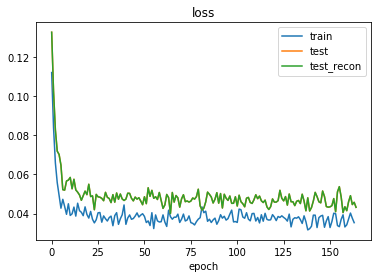

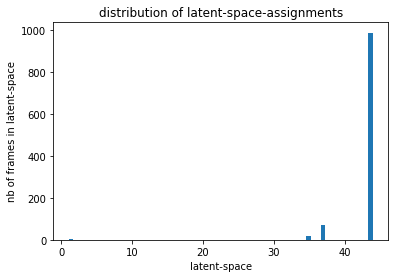

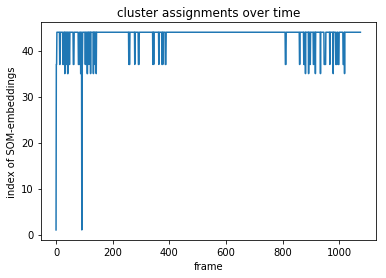

In [389]:
plots.plot_losses(losses)
plots.plot_latent_frame_distribution(res[2], nb_bins=__latent_dim__)
plots.plot_cluster_assignment_over_time(res[2])

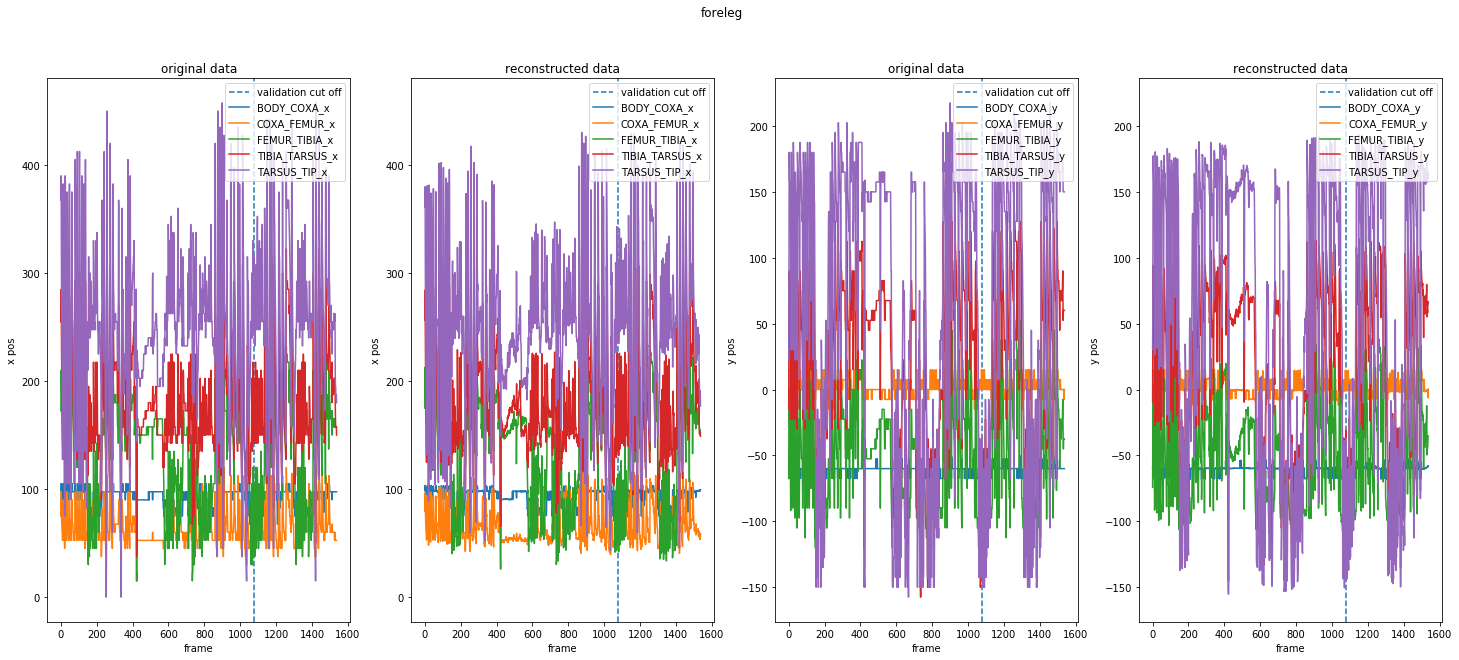

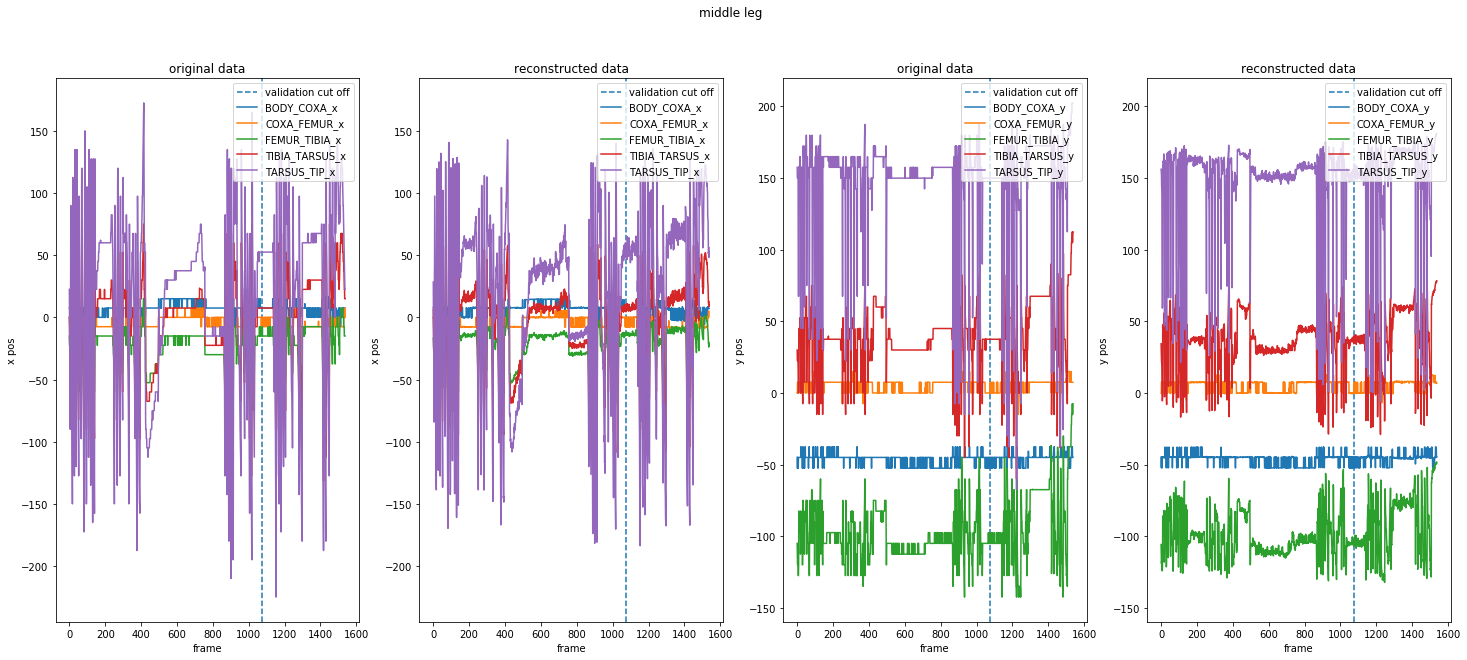

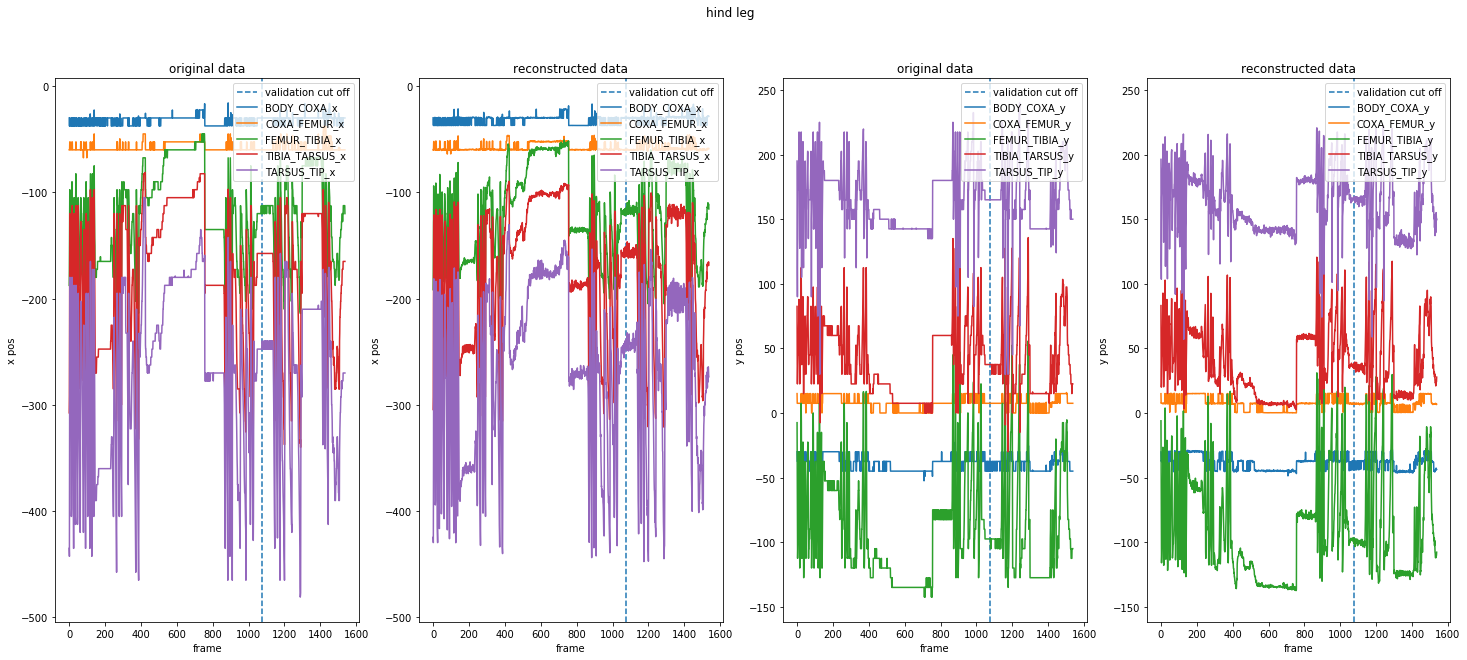

In [390]:
plots.plot_comparing_joint_position_with_reconstructed(joint_positions, 
                                                 np.vstack((reconstructed_from_encoding_train, reconstructed_from_encoding_val)), validation_cut_off=nb_of_data_points)

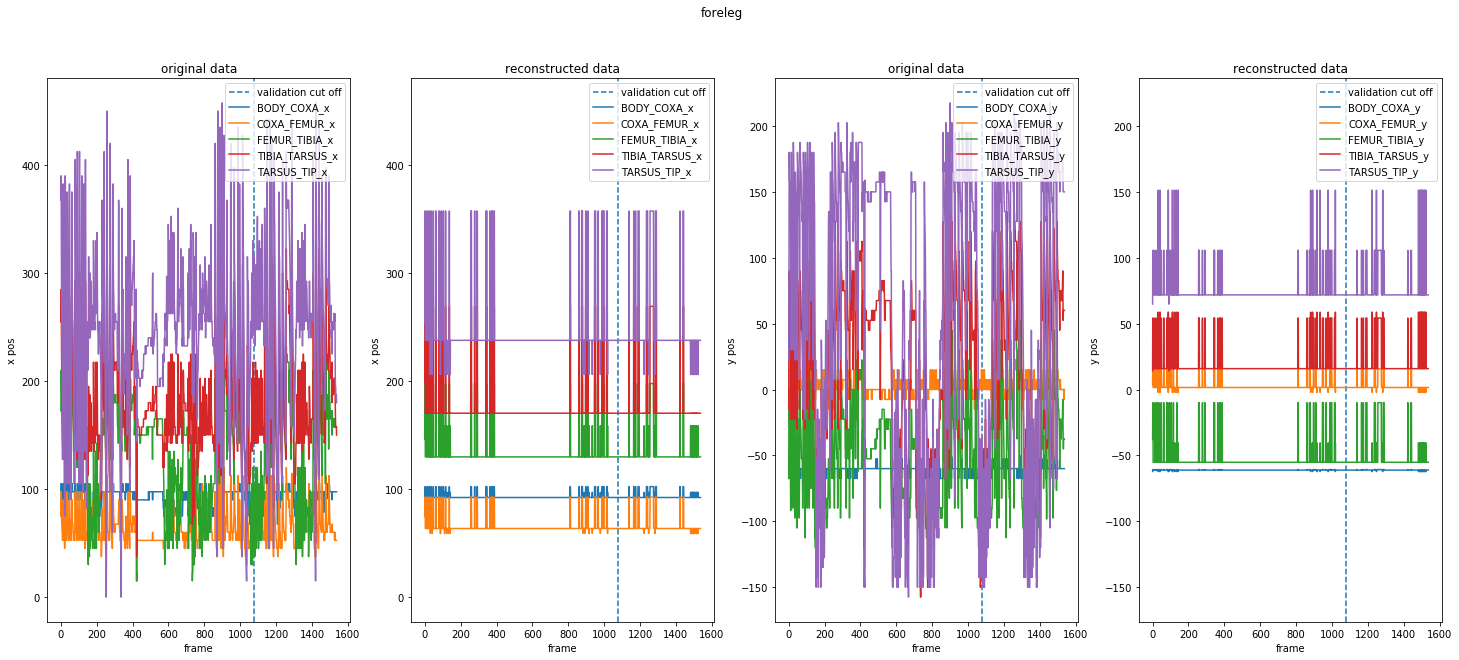

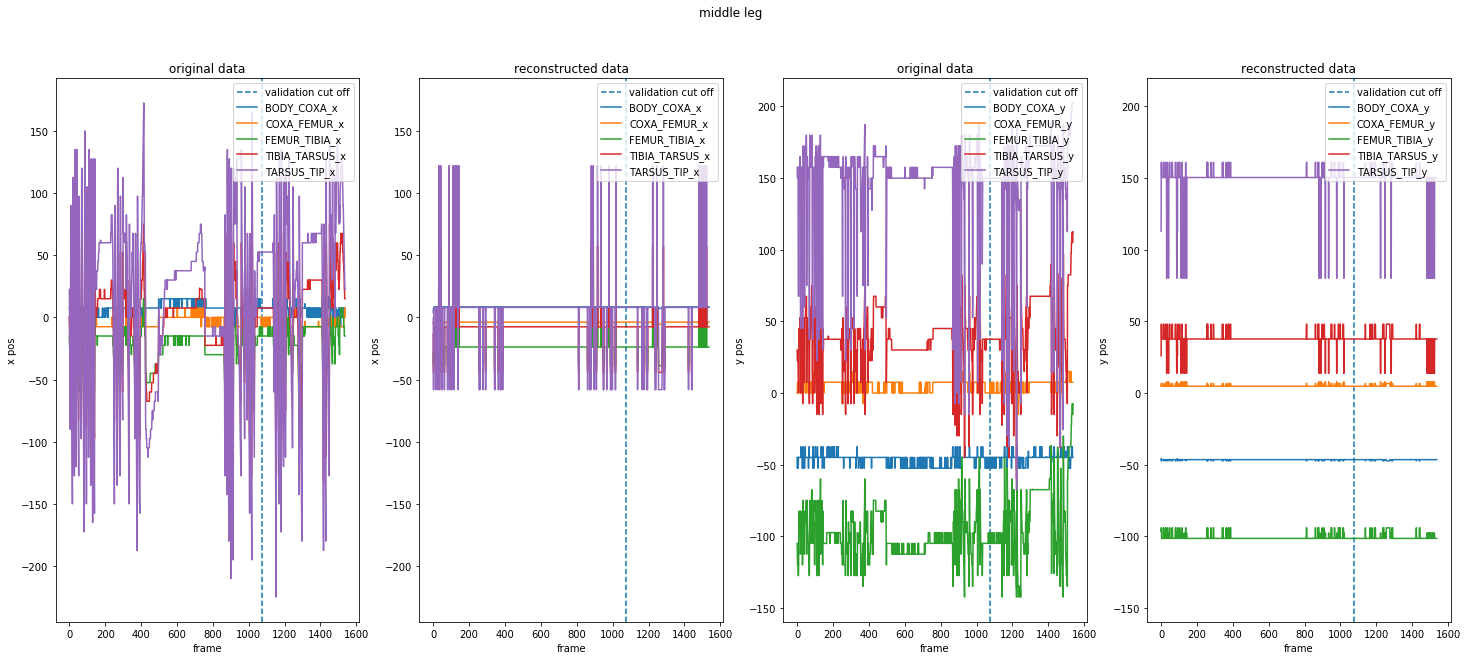

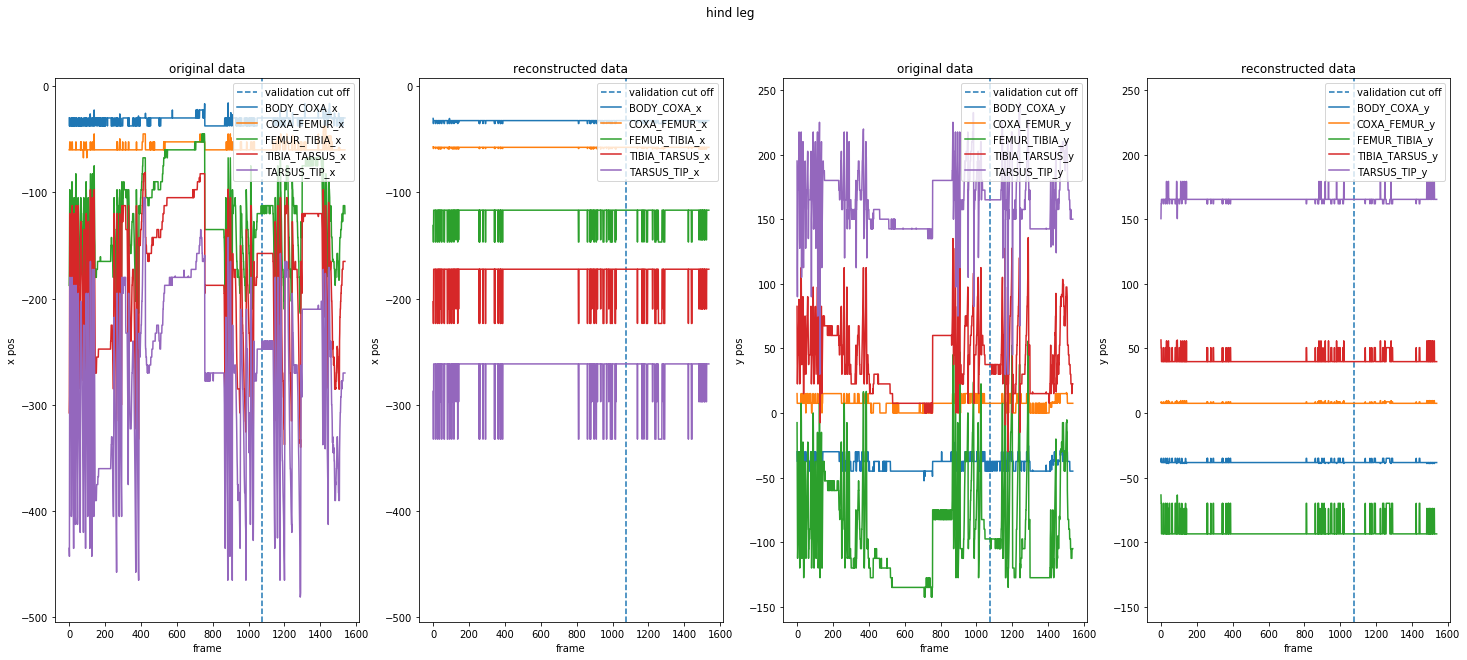

In [391]:
plots.plot_comparing_joint_position_with_reconstructed(joint_positions, 
                                                 np.vstack((reconstructed_from_embedding_train, reconstructed_from_embedding_val)), validation_cut_off=nb_of_data_points)

In [392]:
print(((joint_positions[:len(res[3]),:,:config.NB_DIMS] - reconstructed_from_encoding_train) ** 2).mean())
print(((joint_positions[len(res[3]):,:,:config.NB_DIMS] - reconstructed_from_encoding_val) ** 2).mean())
print(((joint_positions[:len(res[3]),:,:config.NB_DIMS] - reconstructed_from_embedding_train) ** 2).mean())
print(((joint_positions[len(res[3]):,:,:config.NB_DIMS] - reconstructed_from_embedding_val) ** 2).mean())

17.44655840844418
52.30870902449519
1516.3671232122517
1739.0935660483792


## cool videos 

In [375]:
def reverse_pos_pipeline(x, normalisation_term=normalisation_factors):
    """TODO This is again pretty shitty... ultra hidden global variable"""
    return x + normalisation_term[:x.shape[-1]]

In [376]:
from som_vae.helpers.video import _float_to_int_color_

In [468]:
cluster_assignments = np.hstack((res[2], res_val[2]))

cluster_ids = np.unique(cluster_assignments)
cluster_colors = dict(zip(cluster_ids, _float_to_int_color_(sns.color_palette(palette='bright', n_colors=len(cluster_ids)))))

joint_pos_embedding = np.vstack((reconstructed_from_embedding_train, reconstructed_from_embedding_val))
joint_pos_encoding = np.vstack((reconstructed_from_encoding_train, reconstructed_from_encoding_val))

In [469]:
from som_vae.settings.data import EXPERIMENTS

In [331]:
EXPERIMENTS

study_id,fly_id,experiment_id,key
180920_aDN_CsCh,Fly2,001_SG1,180920_aDN_CsCh-Fly2-001_SG1
180920_aDN_CsCh,Fly2,002_SG1,180920_aDN_CsCh-Fly2-002_SG1
180920_aDN_CsCh,Fly2,003_SG1,180920_aDN_CsCh-Fly2-003_SG1
180920_aDN_CsCh,Fly2,004_SG1,180920_aDN_CsCh-Fly2-004_SG1
180920_aDN_CsCh,Fly2,005_SG1,180920_aDN_CsCh-Fly2-005_SG1


In [470]:
images_paths_for_experiments = EXPERIMENTS.map(lambda x: (x, config.positional_data(x)))\
                                          .flat_map(lambda x: [(x[0], config.get_path_for_image(x[0], i)) for i in range(x[1].shape[1])])\
                                          .to_list()

In [471]:
images_paths_for_experiments = np.array(images_paths_for_experiments)[frames_of_interest]

In [472]:
def comparision_video_of_reconstruction(positional_data, cluster_assignments, n_train, images_paths_for_experiments, cluster_id_to_visualize=None, cluster_colors=None):
    """Creates a video (saved as a gif) with the embedding overlay, displayed as an int.

    Args:
        xs: [<pos data>] list of pos data, of shape: [frames, limb, dimensions] (can be just one, but in an array)
            will plot all of them, the colors get lighter
        embeddings: [<embeddings_id>]
            assumed to be in sequence with `get_frame_path` function.
            length of embeddings -> number of frames
        file_path: <str>, default: SEQUENCE_GIF_PATH
            file path used to get
    Returns:
        <str>                            the file path under which the gif was saved
    """
    if cluster_id_to_visualize is None:
        cluster_assignment_idx = list(range(len(cluster_assignments)))
    else:
        cluster_assignment_idx = np.where(cluster_assignments == cluster_id_to_visualize)[0]
    
    
    cluster_ids = np.unique(cluster_assignments)
    if cluster_colors is None:
        cluster_colors = dict(zip(cluster_ids,
                                  video._float_to_int_color_(sns.color_palette(palette='bright', n_colors=len(cluster_ids)))))

    n_frames = positional_data[0].shape[0]
    image_height, image_width, _ = cv2.imread(images_paths_for_experiments[0][1]).shape
    lines_pos = ((np.array(range(n_frames)) / n_frames) * image_width).astype(np.int)[cluster_assignment_idx].tolist()

    _train_test_split_marker = np.int(n_train / n_frames * image_width)
    _train_test_split_marker_colours = [(255, 0, 0), (0, 255, 0)]

    _colors_for_pos_data = [video.lighten_int_colors(skeleton.colors, amount=v) for v in np.linspace(1, 0.3, len(positional_data))]

    def pipeline(frame_nb, frame, frame_id, embedding_id, experiment):
        # kinda ugly... note that some variables are from the upper "frame"
        f = video._add_frame_and_embedding_id_(frame, embedding_id, frame_id)

        # xs are the multiple positional data to plot
        for x_i, x in enumerate(positional_data):
            f = video.plot_drosophila_2d(x[frame_id].astype(np.int), img=f, colors=_colors_for_pos_data[x_i])


        # train test split marker
        if n_train == frame_id:
            cv2.line(f, (_train_test_split_marker, image_height - 20), (_train_test_split_marker, image_height - 40), (255, 255, 255), 1)
        else:
            cv2.line(f, (_train_test_split_marker, image_height - 10), (_train_test_split_marker, image_height - 40), (255, 255, 255), 1)

        # train / test text
        f = cv2.putText(img=f,
                        text='train' if frame_id < n_train else 'test',
                        org=(_train_test_split_marker, image_height - 40),
                        fontFace=1,
                        fontScale=1,
                        color=_train_test_split_marker_colours[0 if frame_id < n_train else 1],
                        thickness=1)

        f = cv2.putText(img=f,
                        text=settings.data._key_(experiment),
                        org=(0, 20),
                        fontFace=1,
                        fontScale=1,
                        color=(255, 255, 255),
                        thickness=1)
        
        # cluster assignment bar
        for line_idx, l in enumerate(lines_pos):
            if line_idx == frame_nb:
                cv2.line(f, (l, image_height), (l, image_height - 20), cluster_colors[cluster_assignments[cluster_assignment_idx[line_idx]]], 2)
            else:
                cv2.line(f, (l, image_height), (l, image_height - 10), cluster_colors[cluster_assignments[cluster_assignment_idx[line_idx]]], 1)

        return f

    frames = [pipeline(frame_nb, cv2.imread(experiment[1]), frame_id, cluster_assignment, experiment[0])
              for frame_nb, (frame_id, cluster_assignment, experiment) in enumerate(zip(cluster_assignment_idx,
                                                                  cluster_assignments[cluster_assignment_idx], 
                                                                  np.array(images_paths_for_experiments)[cluster_assignment_idx]))]
    
    output_path = config.EXPERIMENT_VIDEO_PATH.format(experiment_id='all', vid_id=cluster_id_to_visualize or 'all')
    video._save_frames_(output_path, frames, format='mp4')

    return output_path

In [ ]:
# full video
_p = comparision_video_of_reconstruction([reverse_pos_pipeline(p) for p in [joint_positions, joint_pos_encoding, joint_pos_embedding]],
                                         images_paths_for_experiments=images_paths_for_experiments,
                                         cluster_assignments=cluster_assignments,
                                         cluster_colors=cluster_colors,
                                         n_train=res[2].shape[0])

print(_p)
display_video(_p)

In [474]:
# Creating videos for each cluster
from som_vae.helpers import misc
reload(video)
from collections import OrderedDict

__N_CLUSTER_TO_VIZ__ = 10

_positional_data = [reverse_pos_pipeline(p) for p in [joint_positions, joint_pos_encoding, joint_pos_embedding]]

_t = [(misc.flatten(sequences), cluster_id) for cluster_id, sequences in video.group_by_cluster(cluster_assignments).items()]
_t = sorted(_t, key=lambda x: len(x[0]), reverse=True)

cluster_vids = OrderedDict((p[1], comparision_video_of_reconstruction(_positional_data,
                                                                      cluster_assignments=cluster_assignments,
                                                                      images_paths_for_experiments=images_paths_for_experiments,
                                                                      n_train=res[2].shape[0],
                                                                      cluster_colors=cluster_colors,
                                                                      cluster_id_to_visualize=p[1]))
                    for p in _t[:__N_CLUSTER_TO_VIZ__])

In [475]:
cluster_vids.keys()

odict_keys([44, 37, 35, 1])

In [ ]:
# specific cluster id
cluster_id_of_interest = 57
display_video(cluster_vids[cluster_id_of_interest])

In [ ]:
# order by total size
idx = 0
display_video(list(cluster_vids.values())[idx])

In [ ]:
idx += 1
display_video(list(cluster_vids.values())[idx])

# on latent space

In [396]:
x_hat_latent_train = res[4]
x_hat_latent_test  = res_val[4]

## t-SNE

In [427]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(x_hat_latent_train)

In [445]:
training_frames = frames_idx_with_labels[frames_of_interest][:x_hat_latent_train.shape[0]]
testing_frames = frames_idx_with_labels[frames_of_interest][x_hat_latent_train.shape[0]:]
seen_labels = training_frames.label.unique()

Text(0.5,1,'simple t-SNE on train latent space')

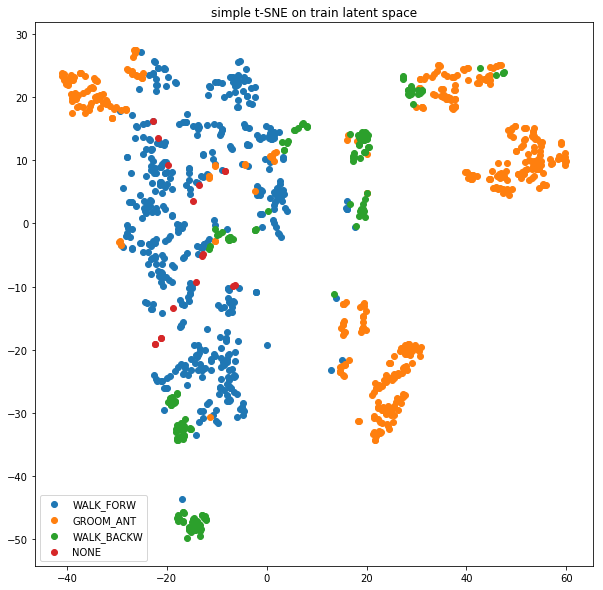

In [430]:
_cs = sns.color_palette(n_colors=len(seen_labels))

plt.figure(figsize=(10, 10))
for idx, l in enumerate(seen_labels):
    _d = X_embedded[training_frames['label'] == l]
    plt.scatter(_d[:, 0], _d[:,1], c=_cs[idx], label=l.name, )
    
plt.legend()
plt.title('simple t-SNE on train latent space')

## linear model

In [449]:
y_train = training_frames.label.apply(lambda x: x.value)
y_test = testing_frames.label.apply(lambda x: x.value)

In [456]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [452]:
mdl = AdaBoostClassifier()
mdl.fit(x_hat_latent_train, y_train)

y_pred_train = mdl.predict(x_hat_latent_train)
y_pred_test = mdl.predict(x_hat_latent_test)

In [454]:
confusion_matrix(y_train, y_pred_train)

array([[196,  30,  39, 201],
       [ 76,  92,   3,   0],
       [ 20,  53, 259,  90],
       [  8,   0,   0,   9]])

tryouts:20: RuntimeWarning: invalid value encountered in true_divide
/home/samuel/.conda/envs/pose/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


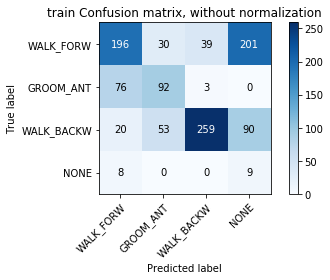

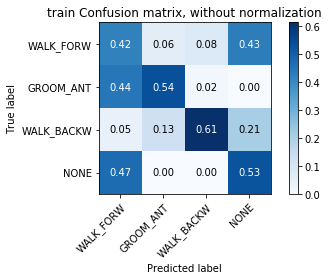

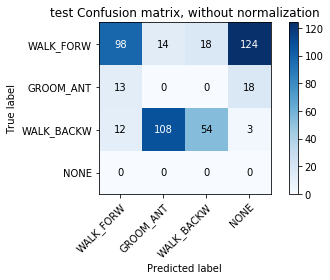

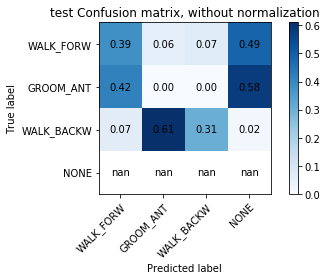

In [477]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_train , y_pred_train, classes=np.array([l.name for l in seen_labels]), 
                      title='train Confusion matrix, without normalization')

plot_confusion_matrix(y_train , y_pred_train, classes=np.array([l.name for l in seen_labels]),  normalize=True,
                      title='train Confusion matrix, without normalization')

plot_confusion_matrix(y_test, y_pred_test, classes=np.array([l.name for l in seen_labels]), 
                      title='test Confusion matrix, without normalization')

plot_confusion_matrix(y_test, y_pred_test, classes=np.array([l.name for l in seen_labels]),  normalize=True,
                      title='test Confusion matrix, without normalization')